<a href="https://www.kaggle.com/code/tarktunataalt/arima-for-annual-temperature-time-series?scriptVersionId=185104968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SUMMARY

This study focuses on forecasting the average annual temperature using historical data from 1900 to 2023, collected from a network of thousands of weather stations across the United States. We applied ARIMA models to this time series data to predict future temperature trends. Both ARIMA(0,1,1) and ARIMA(3,1,0) models were evaluated for their validity. The models were chosen for their ability to handle non-stationary data by differencing. After estimating model parameters and performing diagnostic checks, we found that both models met the validity criteria. However, the ARIMA(0,1,1) model was selected due to its lower AIC value, higher log likelihood, and better error metrics. The analysis indicates that future temperatures are expected to remain relatively stable around 53.8°F, with confidence intervals reflecting some variability. While the ARIMA model provides a reasonable short-term forecast, it does not account for external factors like greenhouse gas emissions or natural climate events, so the predictions should be interpreted with caution.

# INTRODUCTION

Climate change has become one of the most pressing global challenges, affecting weather patterns, sea levels, and ecosystems worldwide. Understanding and predicting temperature trends is crucial for developing effective strategies to mitigate and adapt to these changes. This study utilizes a dataset containing the average annual temperature (°F) for each year from 1900 to 2023, based on observations from a network of thousands of weather stations across the United States. In this study, we will apply the ARIMA model, a time series analysis method, to forecast future temperature trends. This analysis aims to provide predictions of potential future temperature scenarios.

In [97]:
data <- read.csv("/kaggle/input/average-temperature-from-1900-to-2023/Average Temperature 1900-2023.csv")
head(data)

,Year,Average_Fahrenheit_Temperature
,<int>,<dbl>
1,1900,53.9
2,1901,53.5
3,1902,52.1
4,1903,50.6
5,1904,51.8
6,1905,51.7


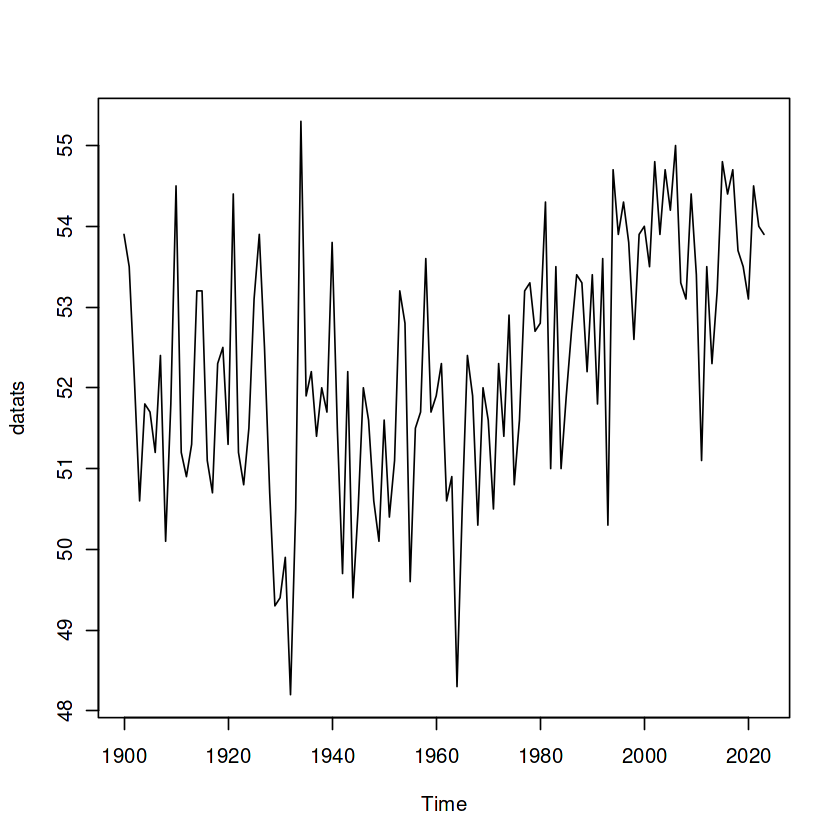

In [98]:
datats <-ts(data$Average_Fahrenheit_Temperature,start=c(1900))
plot.ts(datats)

The time series plot shows the average annual temperature (°F) from 1900 to 2023. The data exhibits fluctuations throughout the years, with noticeable peaks and troughs. There is no clear long-term trend, but there appears to be some increase in variability over time. The temperature values generally range between 48°F and 55°F. This historical pattern will be used to forecast future temperatures using the ARIMA model.

# DEVELOPING AN ARIMA MODEL

## RAW DATA

In [99]:
library(tseries)
library(urca)
adf.test(datats)


	Augmented Dickey-Fuller Test

data:  datats
Dickey-Fuller = -3.7924, Lag order = 4, p-value = 0.02167
alternative hypothesis: stationary



In the Augmented Dickey-Fuller (ADF) test, the null hypothesis (H0) states that the time series has a unit root, meaning it is not stationary. According to the test results, the test statistic is -3.7924 and the p-value is 0.02167. Since the p-value is less than 0.05, we reject the null hypothesis. This means we accept the alternative hypothesis, indicating that the datats time series is stationary.

In [100]:
summary(ur.kpss(datats, type = "tau"))


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.3432 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216


In the KPSS test, the null hypothesis (H0) states that the time series is stationary. The test statistic is 0.3432. Comparing this to the critical values, we see that 0.3432 exceeds all critical values at the 10%, 5%, 2.5%, and 1% significance levels. Therefore, we reject the null hypothesis, indicating that the time series is not stationary.

According to the ADF test, we reject the null hypothesis and conclude that the time series is stationary, while the KPSS test rejects its null hypothesis, indicating that the time series is not stationary.

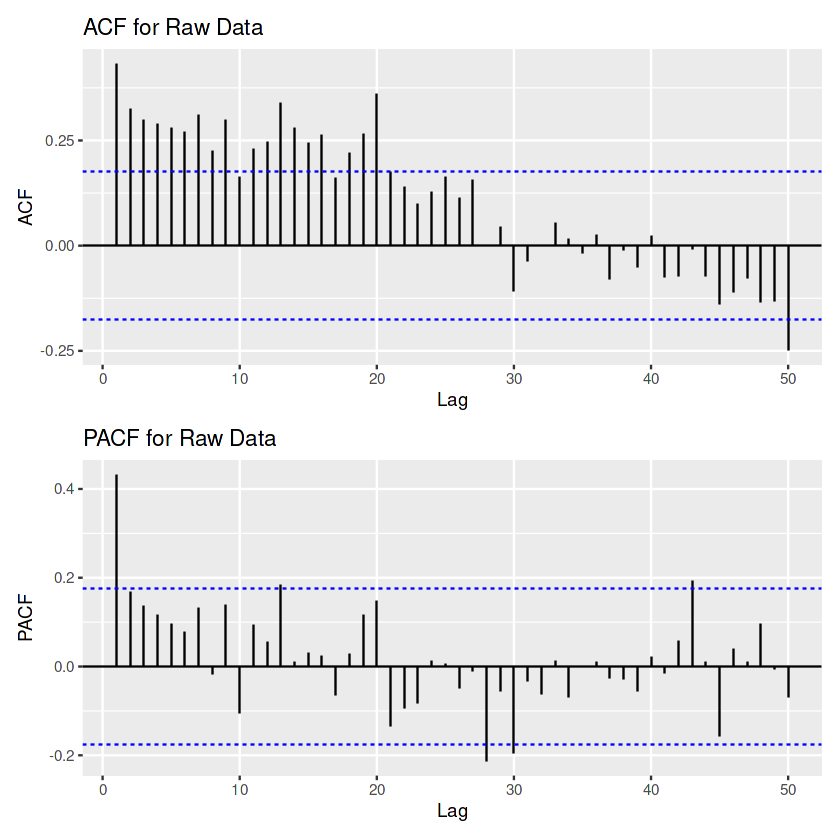

In [101]:
library(forecast)
library(patchwork)
library(ggplot2)

acf_plot <- ggAcf(datats, lag.max = 50) + ggtitle("ACF for Raw Data")
pacf_plot <- ggPacf(datats, lag.max = 50) + ggtitle("PACF for Raw Data ")
acf_plot / pacf_plot

Based on the ACF plot showing many significant lags, it is inferred that the data likely contains persistent patterns and trends, suggesting that the time series is not stationary. This interpretation is aligned with the KPSS test results, which also indicate that the time series is not stationary. Therefore, the assumption is made that the data is non-stationary.

## FIRST-ORDER DIFFERENCED DATA


In [102]:
diff1 <- diff(datats,1)
adf.test(diff1)

Warning message in adf.test(diff1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff1
Dickey-Fuller = -7.7367, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Based on the Augmented Dickey-Fuller test, with a test statistic of -7.7367 and a p-value of 0.01, the null hypothesis is rejected, indicating that the differenced series is stationary, meaning the data is stationary.

In [103]:
summary(ur.kpss(diff1, type = "tau"))



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: tau with 4 lags. 

Value of test-statistic is: 0.0256 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.119 0.146  0.176 0.216



Based on the KPSS test, with a test statistic of 0.0256 which is below all critical values at the 10%, 5%, 2.5%, and 1% significance levels, the null hypothesis of stationarity is not rejected, indicating that the data is stationary.

Based on the Augmented Dickey-Fuller test, with a test statistic of -7.7367 and a p-value of 0.01, the null hypothesis is rejected, indicating that the first differenced series is stationary, and similarly, the KPSS test, with a test statistic of 0.0256 below all critical values, also indicates that the first differenced series is stationary, meaning the first differenced data is more stationary than the raw data according to both tests.

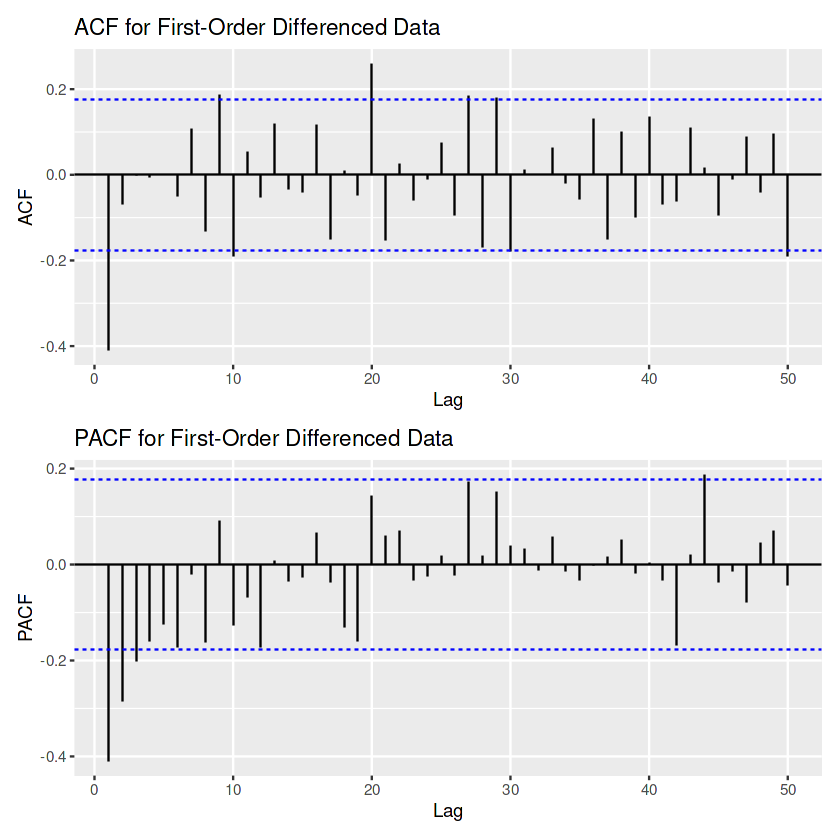

In [104]:
acf_plot <- ggAcf(diff1, lag.max = 50) + ggtitle("ACF for First-Order Differenced Data")
pacf_plot <- ggPacf(diff1, lag.max = 50) + ggtitle("PACF for First-Order Differenced Data")
acf_plot / pacf_plot

Based on the ACF and PACF plots, the ACF plot shows a significant negative spike at the first lag and the PACF plot displays a gradually decaying pattern. The rapid cut-off in the ACF suggests that an ARIMA(0,1,1) model might be appropriate. Alternatively, due to the significant lags in the first 3 lags of the PACF, ARIMA(3,1,0) and ARIMA(3,1,1) models could also be considered. The ACF plot shows spikes particularly at multiples of 10, but since the data is annual, these spikes should not be interpreted as seasonal effects and therefore do not require seasonal evaluation.

## COMPARING COEFFICENTS OF ARIMA MODELS

In [105]:
automodel <- auto.arima(datats, stepwise = FALSE, trace = TRUE, seasonal = FALSE, approximation = FALSE, allowdrift = TRUE, allowmean = TRUE)


 ARIMA(0,1,0)                    : 469.7836
 ARIMA(0,1,0) with drift         : 471.8505
 ARIMA(0,1,1)                    : 420.9879
 ARIMA(0,1,1) with drift         : 422.288
 ARIMA(0,1,2)                    : 420.7437
 ARIMA(0,1,2) with drift         : 421.8992
 ARIMA(0,1,3)                    : 422.8789
 ARIMA(0,1,3) with drift         : 424.0668
 ARIMA(0,1,4)                    : 425.0086
 ARIMA(0,1,4) with drift         : 426.2428
 ARIMA(0,1,5)                    : 427.1094
 ARIMA(0,1,5) with drift         : 428.397
 ARIMA(1,1,0)                    : 449.3769
 ARIMA(1,1,0) with drift         : 451.4784
 ARIMA(1,1,1)                    : 420.7913
 ARIMA(1,1,1) with drift         : 421.9374
 ARIMA(1,1,2)                    : 422.8793
 ARIMA(1,1,2) with drift         : 424.068
 ARIMA(1,1,3)                    : 421.6509
 ARIMA(1,1,3) with drift         : 423.7436
 ARIMA(1,1,4)                    : 423.1513
 ARIMA(1,1,4) with drift         : 425.2973
 ARIMA(2,1,0)                    :

Auto ARIMA suggested the ARIMA(0,1,2) model as the most appropriate.

In [106]:
model1=arima(datats,order=c(0,1,1))
model2=arima(datats,order=c(3,1,0))
model3=arima(datats,order=c(3,1,1))

In [107]:
library(lmtest)
summary(automodel)
coeftest(automodel)

Series: datats 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.7370  -0.1328
s.e.   0.0893   0.0856

sigma^2 = 1.713:  log likelihood = -207.27
AIC=420.54   AICc=420.74   BIC=428.98

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.06123914 1.292784 1.025387 0.05783663 1.968067 0.7863008
                    ACF1
Training set 0.001477071


z test of coefficients:

     Estimate Std. Error z value Pr(>|z|)    
ma1 -0.736967   0.089281 -8.2545   <2e-16 ***
ma2 -0.132825   0.085640 -1.5510   0.1209    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ARIMA(0,1,2) model for the dataset datats was estimated with the following coefficients: ma1 at -0.7370 (standard error 0.0893) and ma2 at -0.1328 (standard error 0.0856). Sigma^2 was estimated at 1.713, with a log likelihood of -207.27, AIC of 420.54, AICc of 420.74, and BIC of 428.98. The absence of a significant spike at the second lag in the ACF plot suggests that the ma2 coefficient is expected to be insignificant. The z-test for the coefficients shows that ma1 is highly significant (p < 2e-16), while ma2, as expected, is insignificant (p = 0.1209). Therefore, the ma2 term proposed by auto ARIMA is insignificant, rendering the model invalid.

In [108]:
summary(model1)
coeftest(model1)


Call:
arima(x = datats, order = c(0, 1, 1))

Coefficients:
          ma1
      -0.8611
s.e.   0.0475

sigma^2 estimated as 1.717:  log likelihood = -208.44,  aic = 420.89

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE     MASE
Training set 0.05491337 1.304978 1.034888 0.04490905 1.987055 0.793586
                  ACF1
Training set 0.1253049


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 -0.86113    0.04755  -18.11 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ARIMA(0,1,1) model for the dataset datats was estimated with the ma1 coefficient at -0.8611 and a standard error of 0.0475. The sigma^2 was estimated at 1.717, with a log likelihood of -208.44 and an AIC of 420.89. Training set error measures show RMSE at 1.3050 and MAPE at 1.9871, indicating a reasonable fit. The z-test for the ma1 coefficient resulted in a z value of -18.11 and a p-value < 2.2e-16, indicating that the ma1 coefficient is highly significant. This suggests that the moving average component is a strong and important part of the model.

In [109]:
summary(model2)
coeftest(model2)


Call:
arima(x = datats, order = c(3, 1, 0))

Coefficients:
          ar1      ar2      ar3
      -0.5879  -0.3993  -0.2108
s.e.   0.0884   0.0970   0.0887

sigma^2 estimated as 1.913:  log likelihood = -214.66,  aic = 437.32

Training set error measures:
                      ME     RMSE      MAE         MPE    MAPE     MASE
Training set 0.004805873 1.377439 1.072759 -0.04517885 2.05909 0.822627
                    ACF1
Training set -0.03422612


z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1 -0.587924   0.088369 -6.6530 2.871e-11 ***
ar2 -0.399324   0.096957 -4.1186 3.812e-05 ***
ar3 -0.210832   0.088666 -2.3778   0.01741 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ARIMA(3,1,0) model for the dataset datats was estimated with coefficients ar1 at -0.5879 (standard error 0.0884), ar2 at -0.3993 (standard error 0.0970), and ar3 at -0.2108 (standard error 0.0887). The sigma^2 was estimated at 1.913, with a log likelihood of -214.66 and an AIC of 437.32. The training set error measures include ME of 0.0048, RMSE of 1.3774, MAE of 1.0728, MPE of -0.0452, MAPE of 2.0591, MASE of 0.8226, and ACF1 of -0.0342. The z-test for the coefficients shows that all AR terms are significant (ar1: p < 2.871e-11, ar2: p < 3.812e-05, ar3: p = 0.01741). While all coefficients are significant, ar3 is less significant compared to ar1 and ar2. Overall, the model is valid with significant AR terms and reasonable error measures.

In [110]:
summary(model3)
coeftest(model3)


Call:
arima(x = datats, order = c(3, 1, 1))

Coefficients:
         ar1      ar2      ar3      ma1
      0.1451  -0.0250  -0.0239  -0.8819
s.e.  0.1018   0.0974   0.0970   0.0482

sigma^2 estimated as 1.684:  log likelihood = -207.23,  aic = 424.47

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.06156448 1.292288 1.024397 0.05850016 1.966347 0.7855414
                     ACF1
Training set 0.0001809306


z test of coefficients:

     Estimate Std. Error  z value Pr(>|z|)    
ar1  0.145109   0.101833   1.4250   0.1542    
ar2 -0.024970   0.097370  -0.2564   0.7976    
ar3 -0.023913   0.096959  -0.2466   0.8052    
ma1 -0.881911   0.048224 -18.2879   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ARIMA(3,1,1) model for the dataset datats was estimated with coefficients ar1 at 0.1451 (standard error 0.1018), ar2 at -0.0250 (standard error 0.0974), ar3 at -0.0239 (standard error 0.0970), and ma1 at -0.8819 (standard error 0.0482). The sigma^2 was estimated at 1.684, with a log likelihood of -207.23 and an AIC of 424.47. The z-test for the coefficients shows that only ma1 is significant (p < 2e-16), while ar1 (p = 0.1542), ar2 (p = 0.7976), and ar3 (p = 0.8052) are insignificant. Therefore, the model is invalid due to the insignificance of the AR terms.

## SELECTING THE FINAL ARIMA MODEL


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 7.5226, df = 9, p-value = 0.5829

Model df: 1.   Total lags used: 10



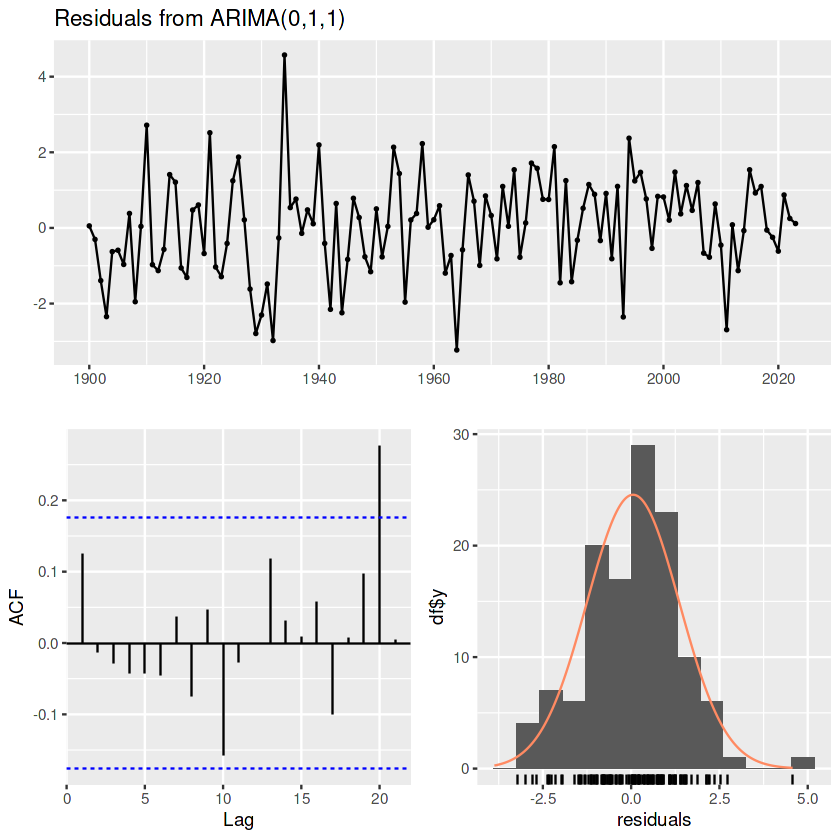

In [111]:
checkresiduals(model1)

The residuals from the ARIMA(0,1,1) model appear to be randomly distributed around 0, indicating no obvious patterns left in the residuals. The ACF plot of the residuals shows no significant autocorrelation, suggesting that the residuals do not exhibit systematic patterns. The histogram of the residuals, along with the overlaid normal distribution curve, suggests that the residuals approximately follow a normal distribution. Overall, the diagnostics indicate that the ARIMA(0,1,1) model fits the data well, with residuals behaving as expected for a well-fitted model.

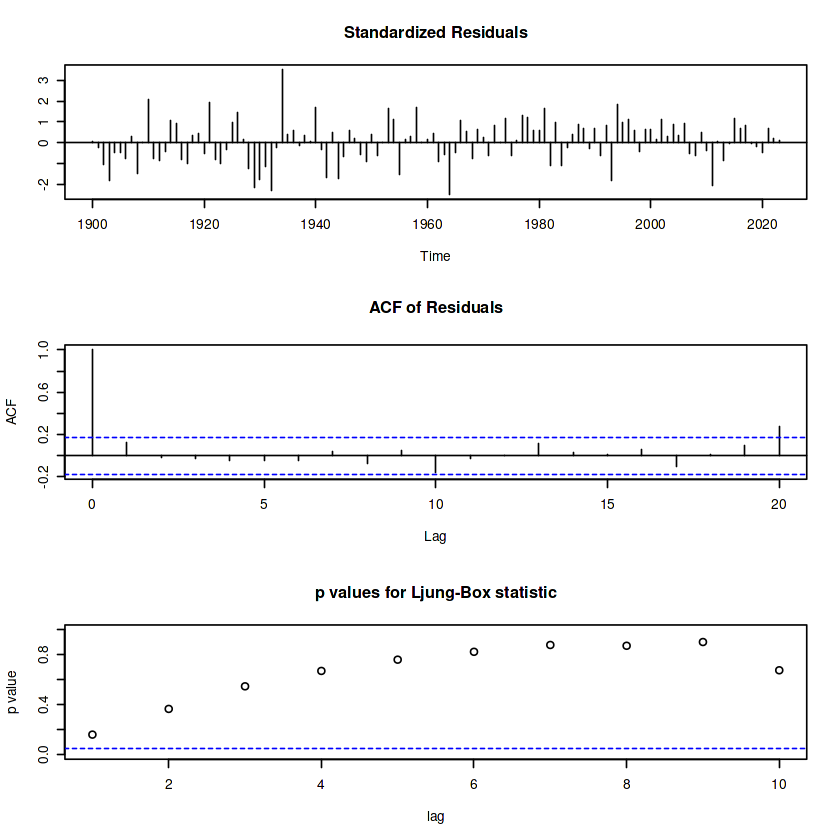

In [112]:
tsdiag(model1)

The standardized residuals plot shows that the residuals are centered around 0, indicating no obvious patterns. The ACF plot of the residuals shows no significant autocorrelations, as all lags fall within the confidence bounds. The p-values for the Ljung-Box test are consistently high, indicating that there is no significant autocorrelation in the residuals. Overall, these diagnostics suggest that the model fits the data well, with residuals behaving randomly and exhibiting no significant autocorrelation.

In [113]:
Box.test(model1$residuals,lag=6)
Box.test(model1$residuals,lag=12)
Box.test(model1$residuals,lag=18)
Box.test(model1$residuals,lag=24)
Box.test(model1$residuals,lag=36)


	Box-Pierce test

data:  model1$residuals
X-squared = 2.7836, df = 6, p-value = 0.8355



	Box-Pierce test

data:  model1$residuals
X-squared = 7.1011, df = 12, p-value = 0.8509



	Box-Pierce test

data:  model1$residuals
X-squared = 10.669, df = 18, p-value = 0.9079



	Box-Pierce test

data:  model1$residuals
X-squared = 21.67, df = 24, p-value = 0.599



	Box-Pierce test

data:  model1$residuals
X-squared = 31.031, df = 36, p-value = 0.7038


The Box-Pierce test results for the model's residuals show consistently high p-values across different degrees of freedom (df). Specifically, p-values are 0.8355, 0.8509, 0.9079, 0.599, and 0.7038. These high p-values indicate that there is no significant autocorrelation in the residuals, suggesting that the model fits the data well.

In [114]:
shapiro.test(model1$residuals)


	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.98922, p-value = 0.4423



The Shapiro-Wilk normality test for the model's residuals resulted in W = 0.98922 with a p-value of 0.4423, indicating that the residuals are normally distributed. Combined with the high p-values from the Box-Pierce test, which show no significant autocorrelation in the residuals, it can be concluded that the model meets all validity criteria.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,0)
Q* = 13.817, df = 7, p-value = 0.05454

Model df: 3.   Total lags used: 10



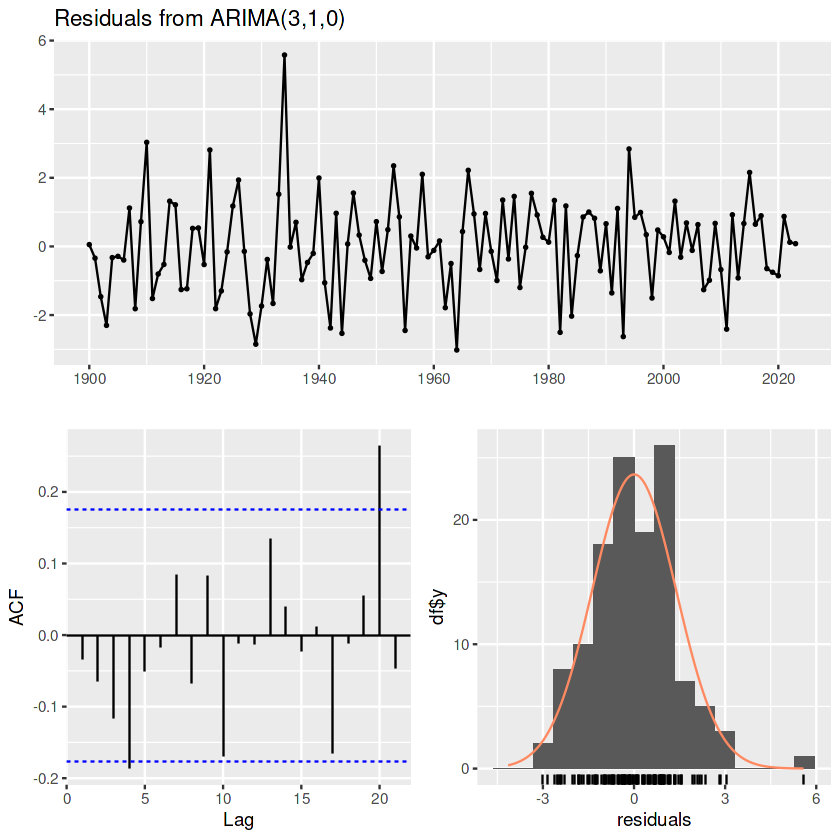

In [115]:
checkresiduals(model2)

The residual diagnostics for the ARIMA(3,1,0) model indicate that the residuals are centered around zero, with no significant autocorrelation as shown by the ACF plot where most autocorrelations fall within the confidence bounds. Additionally, the histogram of the residuals, overlaid with a normal distribution curve, suggests that the residuals are approximately normally distributed. Overall, these diagnostics suggest that the residuals behave as expected for a well-fitted model.

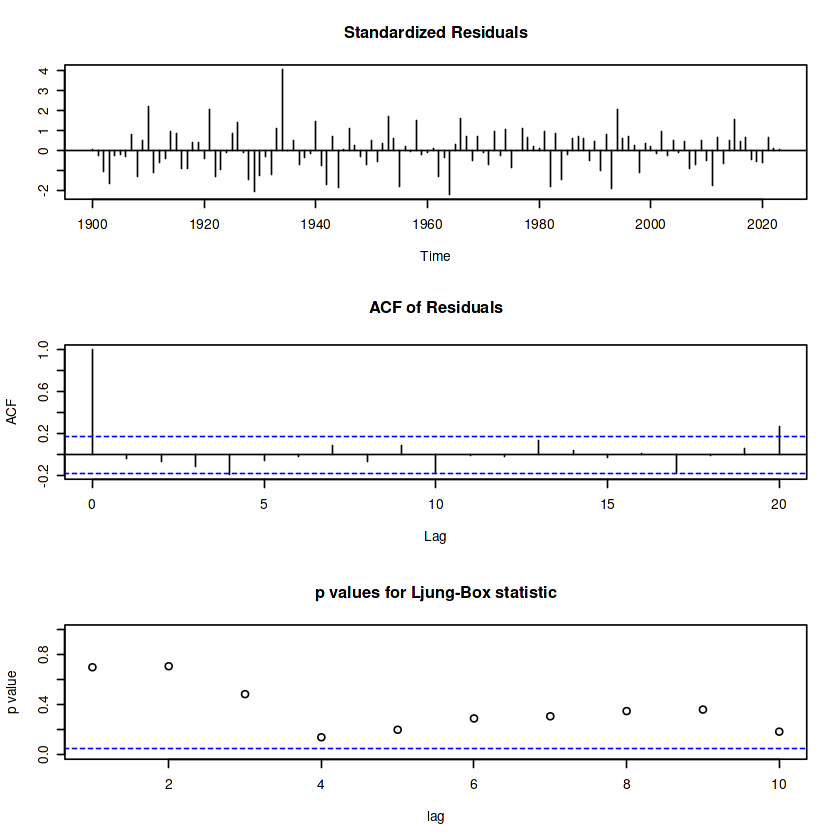

In [116]:
tsdiag(model2)

The residual diagnostics for the ARIMA(3,1,0) model show that the standardized residuals are centered around zero, indicating no obvious patterns. The ACF plot of the residuals reveals that most autocorrelations are within the confidence bounds, suggesting no significant autocorrelation. Additionally, the p-values for the Ljung-Box test are consistently high, further indicating the absence of significant autocorrelation in the residuals. Overall, these diagnostics suggest that the model fits the data well, with residuals behaving as expected.








In [117]:
Box.test(model2$residuals,lag=6)
Box.test(model2$residuals,lag=12)
Box.test(model2$residuals,lag=18)
Box.test(model2$residuals,lag=24)
Box.test(model2$residuals,lag=36)


	Box-Pierce test

data:  model2$residuals
X-squared = 7.0433, df = 6, p-value = 0.3169



	Box-Pierce test

data:  model2$residuals
X-squared = 12.955, df = 12, p-value = 0.3723



	Box-Pierce test

data:  model2$residuals
X-squared = 18.91, df = 18, p-value = 0.3974



	Box-Pierce test

data:  model2$residuals
X-squared = 30.208, df = 24, p-value = 0.178



	Box-Pierce test

data:  model2$residuals
X-squared = 43.102, df = 36, p-value = 0.1935


The Box-Pierce test results for the residuals of the model show consistently high p-values across different degrees of freedom (df). Specifically, the p-values are 0.3169, 0.3723, 0.3974, 0.178, and 0.1935. These high p-values indicate that there is no significant autocorrelation in the residuals. Overall, these results suggest that the model adequately captures the data's structure, with residuals behaving as expected for a well-fitted model.

In [118]:
shapiro.test(model2$residuals)


	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.97819, p-value = 0.04219


The Shapiro-Wilk normality test for the model's residuals resulted in W = 0.97819 with a p-value of 0.04219. This p-value is slightly above the typical 0.05 threshold, suggesting that the residuals can be considered to be normally distributed, albeit marginally. Therefore, it can be said that the residuals are borderline normally distributed.

The ARIMA(0,1,1) model is selected as the final model over the ARIMA(3,1,0) model for several reasons. First, the ACF and PACF graphs for the ARIMA(0,1,1) model exhibit a clearer cut-off, indicating a better fit for the data compared to the ARIMA(3,1,0) model.

In terms of model selection criteria, the ARIMA(0,1,1) model has a lower AIC value (420.89) compared to the ARIMA(3,1,0) model (437.32), suggesting a better fit. Additionally, the ARIMA(0,1,1) model has a higher log likelihood (-208.44) compared to the ARIMA(3,1,0) model (-214.66), further indicating its superior fit to the data.

Regarding error metrics, the ARIMA(0,1,1) model outperforms the ARIMA(3,1,0) model in several key areas. The ARIMA(0,1,1) model has a Mean Error (ME) of 0.0549, a Root Mean Square Error (RMSE) of 1.3050, a Mean Absolute Error (MAE) of 1.0349, a Mean Percentage Error (MPE) of 0.0449, a Mean Absolute Percentage Error (MAPE) of 1.9871, a Mean Absolute Scaled Error (MASE) of 0.7936, and a first-order autocorrelation (ACF1) of 0.1253. In comparison, the ARIMA(3,1,0) model has higher error metrics, indicating a less accurate fit.

The residual analysis also supports the selection of the ARIMA(0,1,1) model. The p-values from the Ljung-Box test for the residuals are higher for the ARIMA(0,1,1) model, indicating better residual behavior with no significant autocorrelation. Furthermore, the Shapiro-Wilk normality test for the residuals of the ARIMA(0,1,1) model resulted in a W value suggesting that the residuals are normally distributed. In contrast, the residuals of the ARIMA(3,1,0) model are only borderline normal.

Based on these criteria, the ARIMA(0,1,1) model is chosen as the final model due to its better fit indicated by lower AIC, higher log likelihood, better error metrics, higher p-values for residuals, and more normal residual distribution.

# CONCLUSION

In [119]:
library(forecast)

forecast_data <- forecast(model1, h = 24)

forecast_data

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2024       53.80052 52.12136 55.47969 51.23246 56.36859
2025       53.80052 52.10524 55.49581 51.20781 56.39324
2026       53.80052 52.08928 55.51177 51.18340 56.41765
2027       53.80052 52.07346 55.52759 51.15921 56.44184
2028       53.80052 52.05779 55.54326 51.13525 56.46580
2029       53.80052 52.04226 55.55879 51.11149 56.48956
2030       53.80052 52.02686 55.57418 51.08795 56.51310
2031       53.80052 52.01160 55.58945 51.06460 56.53645
2032       53.80052 51.99647 55.60458 51.04146 56.55959
2033       53.80052 51.98146 55.61959 51.01850 56.58255
2034       53.80052 51.96657 55.63448 50.99574 56.60531
2035       53.80052 51.95181 55.64924 50.97316 56.62789
2036       53.80052 51.93716 55.66389 50.95075 56.65030
2037       53.80052 51.92262 55.67842 50.92852 56.67252
2038       53.80052 51.90820 55.69285 50.90647 56.69458
2039       53.80052 51.89389 55.70716 50.88458 56.71647
2040       53.80052 51.87968 55.72137 50.86285 5

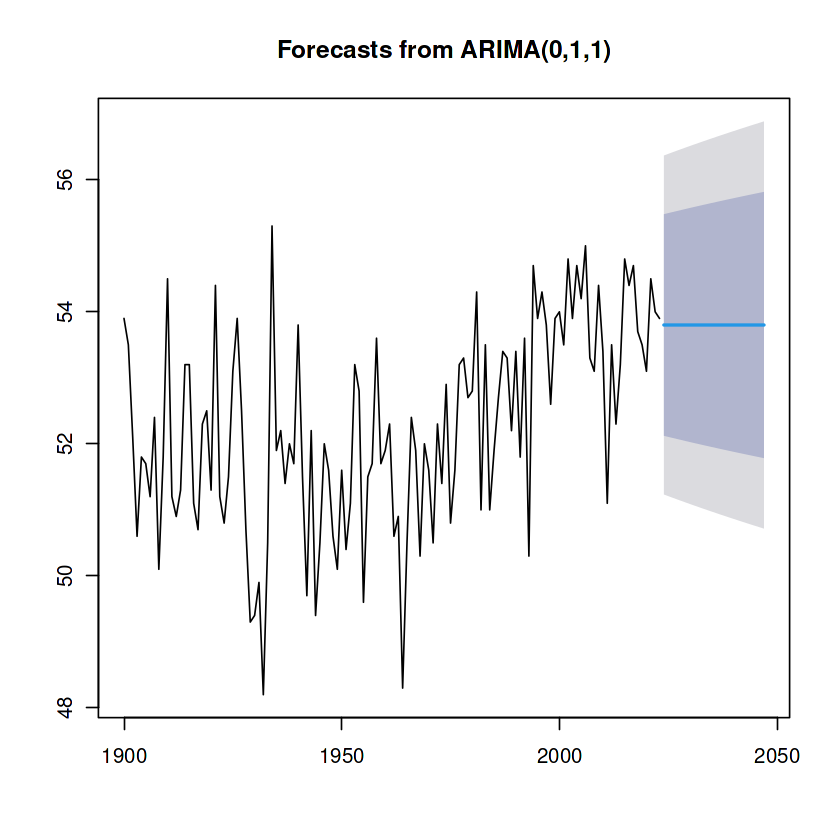

In [120]:
plot(forecast_data)

The forecast plot for the average annual temperature using the ARIMA(0,1,1) model shows historical data from 1900 to 2023 and projected temperatures from 2024 onwards. The point forecast for future temperatures is shown as a blue line, remaining stable around 53.8°F.

The shaded areas around the forecast line represent confidence intervals:

The darker shaded area indicates the 80% confidence interval, within which future temperatures are expected to fall with 80% probability.
The lighter shaded area represents the 95% confidence interval, within which temperatures are expected to fall with 95% probability.
From the plot, the following conclusions can be drawn:

The forecasted average annual temperatures remain relatively stable, showing no significant upward or downward trend.
The confidence intervals widen over future years, reflecting increasing uncertainty in long-term forecasts.
However, it is important to consider the limitations of this model. The ARIMA(0,1,1) model relies on historical data, assuming that future patterns will follow past trends and does not account for potential changes in external factors (e.g., greenhouse gas emissions, land use changes). Additionally, it does not include natural climate events such as El Niño* and La Niña*-, which result from changes in sea surface temperatures in the Pacific Ocean and can affect global weather patterns. El Niño periods are associated with warmer temperatures, while La Niña periods are associated with cooler temperatures. The ARIMA model only forecasts based on past temperature data and has no knowledge of how these external factors may change in the future. Therefore, the model's forecasts may not fully reflect the impacts of these external factors.

According to current climate science, it is unlikely that global average temperatures will remain stable without fluctuations. Human-induced climate change is expected to cause a long-term increase in global temperatures, along with increased variability and extreme weather events. Hence, while the ARIMA(0,1,1) model provides a reasonable short-term forecast based on past data, it may not fully capture the complexities and trends of future climate changes.

In conclusion, the ARIMA(0,1,1) model predicts that the average annual temperature will remain around 53.8°F over the next few decades, accounting for some variability within the confidence intervals. However, these forecasts should be interpreted with caution and supported by more comprehensive climate models considering the broader context of climate change.

*El Niño is a climate event characterized by higher-than-normal sea surface temperatures in the eastern Pacific Ocean, affecting global climate patterns.

*-La Niña is a climate event characterized by lower-than-normal sea surface temperatures in the eastern Pacific Ocean, affecting global climate patterns.